In [5]:
import pandas as pd
import numpy as np
import aqi
from fancyimpute import KNN
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt
import warnings
import logging
import seaborn as sns
warnings.filterwarnings('ignore')

In [6]:
data_path = r"D:\AQI_forecasting\backend\data\bangkok-air-quality.csv"
df = pd.read_csv(data_path)
df.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

In [7]:
def remove_whitespace_cols(df):
    df.columns = df.columns.str.strip()
    return df

def cleaning_data(df):
    
    df = remove_whitespace_cols(df)
    if 'date' not in df.columns:
        raise ValueError('date column not found')
    else:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    try:
        for col in df.columns:
            if col != 'date':
                df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.sort_values('date').reset_index(drop=True)
    except ValueError:
        raise ValueError('Invalid data in columns')
    return df

data_1 = remove_whitespace_cols(df)
data_2 = cleaning_data(data_1)
data_2.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], dtype='object')

In [8]:
def calc_aqi(row:pd.Series):
    pollutants = {
        'pm25': aqi.POLLUTANT_PM25,
        'pm10': aqi.POLLUTANT_PM10,
        'o3': aqi.POLLUTANT_O3_8H,
        'no2': aqi.POLLUTANT_NO2_1H,
        'so2': aqi.POLLUTANT_SO2_1H,
        'co': aqi.POLLUTANT_CO_8H
    }
    aqi_values = []
    for pollutant, aqi_pollutant in pollutants.items():
        if row[pollutant] is not None and not np.isnan(row[pollutant]):
            try:
                aqi_values.append(aqi.to_aqi([(aqi_pollutant, row[pollutant])]))
            except TypeError:
                continue
    if len(aqi_values) == 0:
        return np.nan
    return np.max(aqi_values)

data_2['aqi'] = data_2.apply(calc_aqi, axis=1)
data_2.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'aqi'], dtype='object')

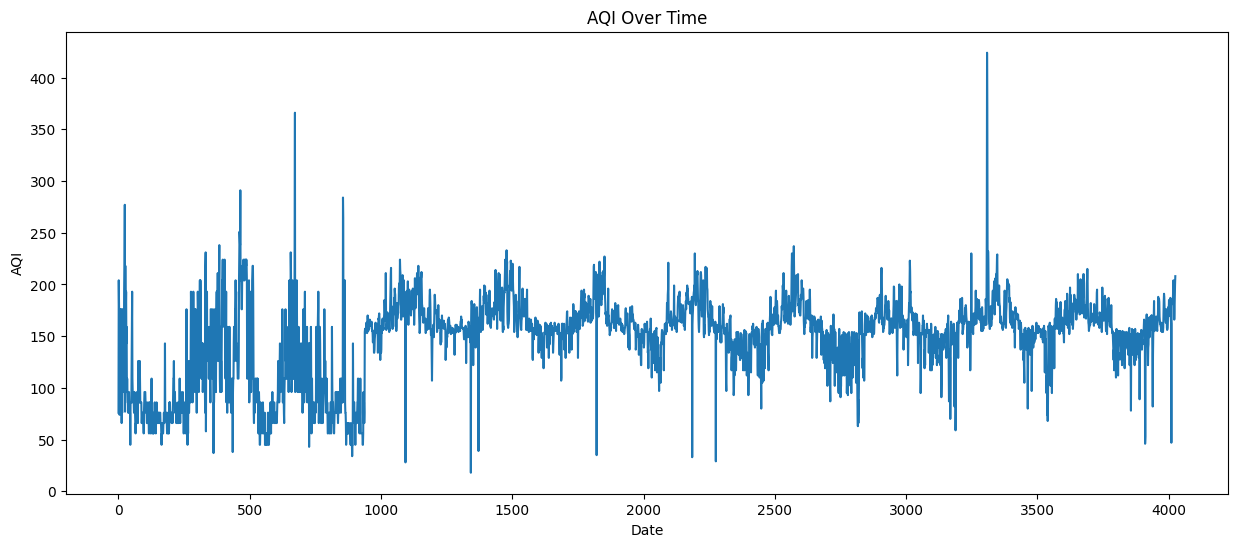

In [9]:
data_2['aqi'] = pd.to_numeric(data_2['aqi'], errors='coerce')
data_2['aqi'].plot(figsize=(15, 6), title='AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()

In [10]:
def propocees_data(df):
    if df is None:
        raise ValueError('Dataframe is None')
    try:
        if 'date' not in df.columns or 'aqi' not in df.columns:
            raise KeyError('Columns not found')
        aqi_df = df[['date', 'aqi']].rename(columns={'date': 'ds', 'aqi': 'y'})
        aqi_df = aqi_df.set_index('ds').asfreq('D')
        
        aqi_df['y'] = pd.to_numeric(aqi_df['y'], errors='coerce')
        aqi_df['y'] = aqi_df['y'].interpolate(method='time')
        aqi_df['unique_id'] = int(1)
        
        # Reset the index so 'ds' remains a column
        aqi_df = aqi_df.reset_index()
    except KeyError:
        raise ValueError('Columns not found')
    return aqi_df


data_3 = propocees_data(data_2)
print(data_3.isnull().sum())
print(data_3.columns)

ds           0
y            0
unique_id    0
dtype: int64
Index(['ds', 'y', 'unique_id'], dtype='object')


In [11]:
def impute_missing_data(df):
    imputer = KNN(k=3)
    # Separate the 'ds' column
    ds = df['ds']
    df = df.drop(columns=['ds'])
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    # Add the 'ds' column back
    imputed_df['ds'] = ds
    return imputed_df

data_4 = impute_missing_data(data_3)

d:\AQI_forecasting\.venv\Lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Imputing row 1/4034 with 0 missing, elapsed time: 1.152
Imputing row 101/4034 with 0 missing, elapsed time: 1.153
Imputing row 201/4034 with 0 missing, elapsed time: 1.153
Imputing row 301/4034 with 0 missing, elapsed time: 1.153
Imputing row 401/4034 with 0 missing, elapsed time: 1.153
Imputing row 501/4034 with 0 missing, elapsed time: 1.153
Imputing row 601/4034 with 0 missing, elapsed time: 1.153
Imputing row 701/4034 with 0 missing, elapsed time: 1.154
Imputing row 801/4034 with 0 missing, elapsed time: 1.154
Imputing row 901/4034 with 0 missing, elapsed time: 1.154
Imputing row 1001/4034 with 0 missing, elapsed time: 1.154
Imputing row 1101/4034 with 0 missing, elapsed time: 1.154
Imputing row 1201/4034 with 0 missing, elapsed time: 1.154
Imputing row 1301/4034 with 0 missing, elapsed time: 1.155
Imputing row 1401/4034 with 0 missing, elapsed time: 1.155
Imputing row 1501/4034 with 0 missing, elapsed time: 1.155
Imputing row 1601/4034 with 0 missing, elapsed time: 1.155
Imputing 

Index(['y', 'unique_id', 'ds'], dtype='object')
y                   float64
unique_id           float64
ds           datetime64[ns]
dtype: object


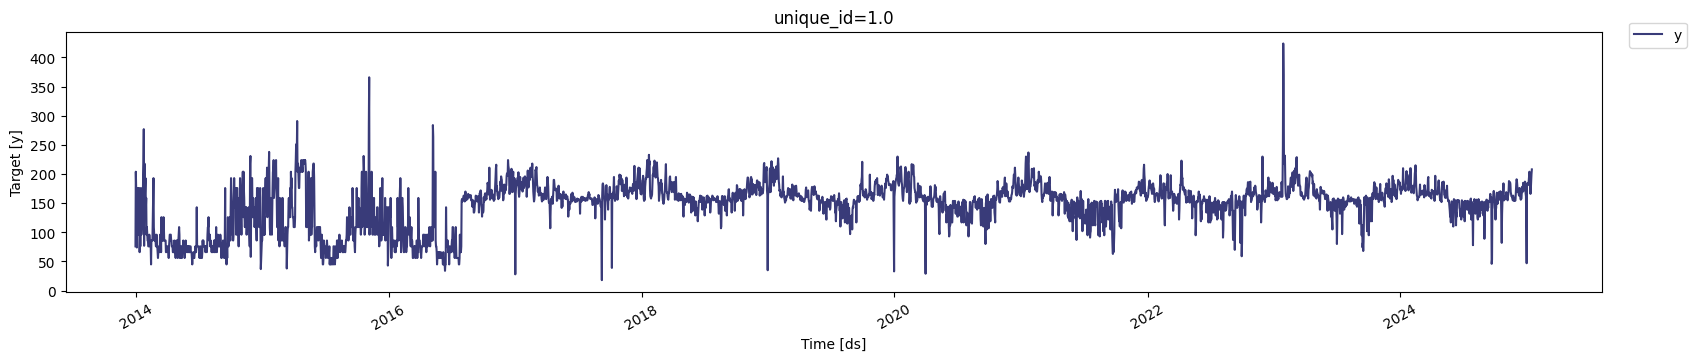

In [12]:
def split_data(df):
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    return train, test

print(data_4.columns)
print(data_4.dtypes)
StatsForecast.plot(data_4)


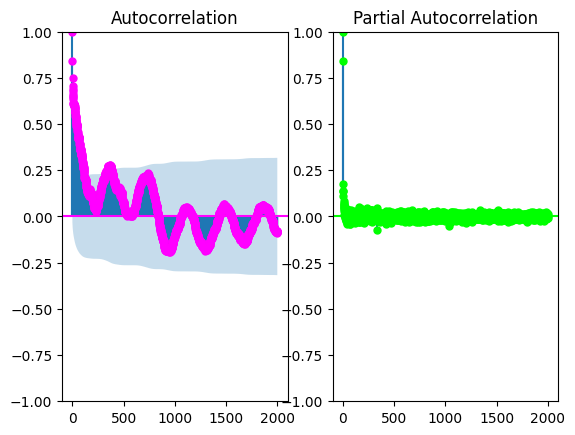

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(data_4["y"],  lags=2000, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(data_4["y"],  lags=2000, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();


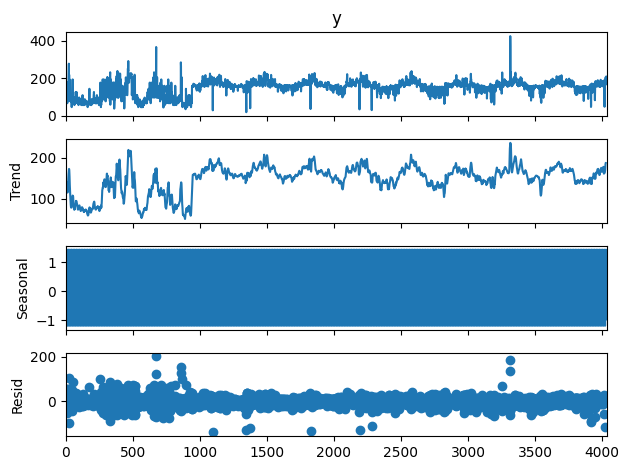

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(data_4["y"], model = "add", period=12)
a.plot();


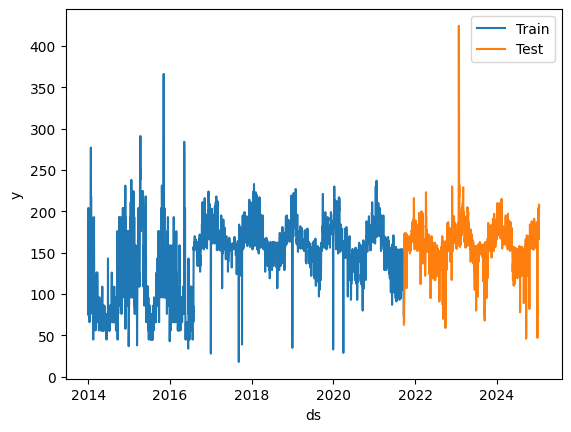

In [15]:

train_size = int(len(data_4) * 0.7)
train_df, test_df = data_4.iloc[:train_size], data_4.iloc[train_size:]

sns.lineplot(train_df,x="ds", y="y", label="Train")
sns.lineplot(test_df, x="ds", y="y", label="Test")
plt.show()


    

In [16]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

season_length = 12 # Monthly data 
horizon = len(test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='MS')
#train model
sf.fit(df=train_df)
print(arima_string(sf.fitted_[0,0].model_))



ARIMA(2,1,1)(1,0,1)[12]                   


In [17]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])


dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(2, 1, 1, 1, 12, 1, 0)


In [18]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual


,residual Model
0,0.076000
1,115.247764
2,2.177276
3,2.508277
4,-73.341900
...,...
2818,26.741210
2819,-0.120706
2820,8.645700
2821,-45.146347


C:\Users\user\AppData\Local\Temp\ipykernel_4656\2963307023.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


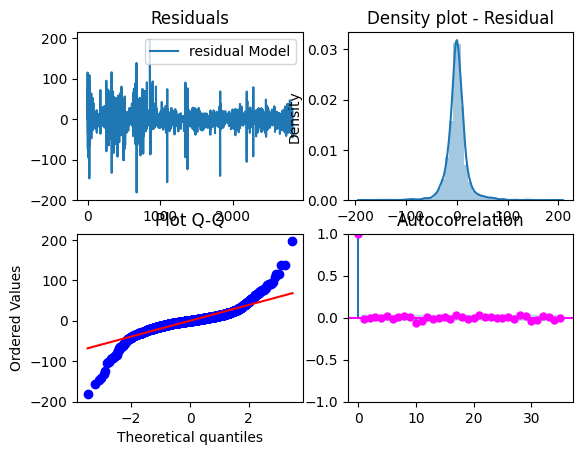

In [19]:
from scipy import stats

fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();


In [20]:
Y_hat_df = sf.forecast(df=train_df, h=horizon, fitted=True)
Y_hat_df.head()


KeyboardInterrupt: 

In [35]:
values=sf.forecast_fitted_values()
values


,unique_id,ds,y,AutoARIMA
0,1.0,2013-12-31,76.0,75.924000
1,1.0,2014-01-01,204.0,88.752236
2,1.0,2014-01-02,176.0,173.822724
3,1.0,2014-01-03,159.0,156.491723
4,1.0,2014-01-04,74.0,147.341900
...,...,...,...,...
2818,1.0,2021-09-18,153.0,126.258790
2819,1.0,2021-09-19,142.0,142.120706
2820,1.0,2021-09-20,147.0,138.354300
2821,1.0,2021-09-21,95.0,140.146347


In [37]:
sf.forecast(df=train_df, h=12, level=[95])


,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,1.0,2021-10-01,99.351292,57.705442,140.997143
1,1.0,2021-11-01,112.317073,63.873866,160.760279
2,1.0,2021-12-01,116.977607,66.168718,167.786497
3,1.0,2022-01-01,116.315009,64.196646,168.433371
4,1.0,2022-02-01,116.970505,63.853401,170.087608
5,1.0,2022-03-01,120.022830,66.015399,174.030261
6,1.0,2022-04-01,119.233752,64.380926,174.086577
7,1.0,2022-05-01,117.240319,61.565471,172.915168
8,1.0,2022-06-01,118.711717,62.230478,175.192957
9,1.0,2022-07-01,117.510063,60.235066,174.785059


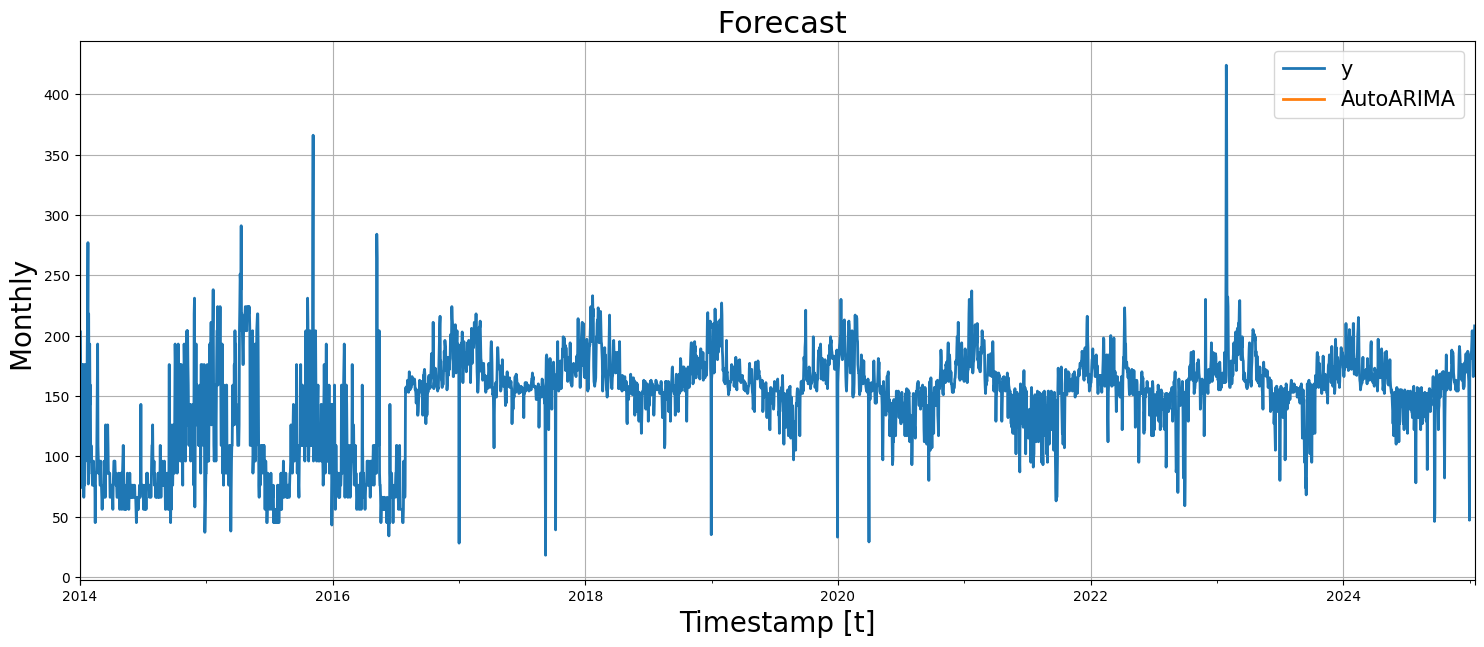

In [38]:
Y_hat_df = test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


In [39]:
sf.predict(h=12)


,unique_id,ds,AutoARIMA
0,1.0,2021-10-01,99.351292
1,1.0,2021-11-01,112.317073
2,1.0,2021-12-01,116.977607
3,1.0,2022-01-01,116.315009
4,1.0,2022-02-01,116.970505
5,1.0,2022-03-01,120.022830
6,1.0,2022-04-01,119.233752
7,1.0,2022-05-01,117.240319
8,1.0,2022-06-01,118.711717
9,1.0,2022-07-01,117.510063


In [40]:
forecast_df = sf.predict(h=12, level = [80, 95]) 
forecast_df


,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
0,1.0,2021-10-01,99.351292,57.705442,72.120534,126.582050,140.997143
1,1.0,2021-11-01,112.317073,63.873866,80.641763,143.992383,160.760279
2,1.0,2021-12-01,116.977607,66.168718,83.755460,150.199755,167.786497
3,1.0,2022-01-01,116.315009,64.196646,82.236643,150.393374,168.433371
4,1.0,2022-02-01,116.970505,63.853401,82.239098,151.701912,170.087608
5,1.0,2022-03-01,120.022830,66.015399,84.709269,155.336391,174.030261
6,1.0,2022-04-01,119.233752,64.380926,83.367417,155.100086,174.086577
7,1.0,2022-05-01,117.240319,61.565471,80.836493,153.644146,172.915168
8,1.0,2022-06-01,118.711717,62.230478,81.780620,155.642815,175.192957
9,1.0,2022-07-01,117.510063,60.235066,80.059956,154.960170,174.785059


In [41]:
df_plot=pd.concat([df, forecast_df]).set_index('ds').tail(220)
df_plot


,date,pm25,pm10,o3,no2,so2,co,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,,,,,,,,
NaT,2014-09-10,NaN,21.0,21.0,20.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2014-09-11,NaN,23.0,17.0,18.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2014-09-12,NaN,26.0,19.0,15.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2014-09-13,NaN,26.0,21.0,13.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2014-09-14,NaN,25.0,17.0,15.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,117.240319,61.565471,80.836493,153.644146,172.915168
2022-06-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,118.711717,62.230478,81.780620,155.642815,175.192957
2022-07-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,117.510063,60.235066,80.059956,154.960170,174.785059


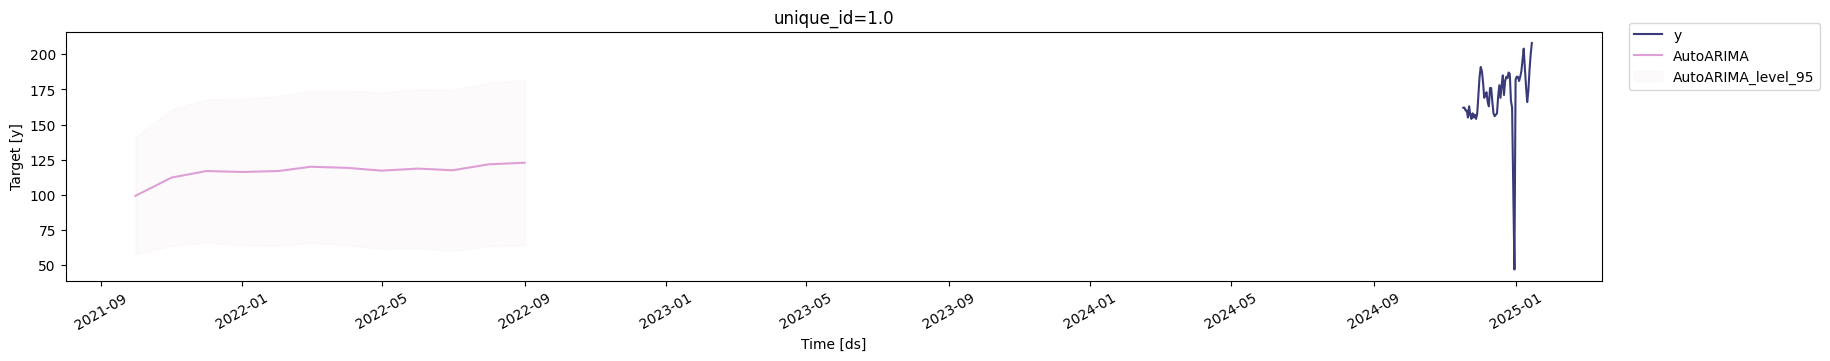

In [44]:
sf.plot(data_4, forecast_df, level=[95], max_insample_length=12 * 5)


Loading data from: D:\AQI_forecasting\backend\data\bangkok-air-quality.csv
Data loaded. Shape: (4026, 7)
Cleaning data.
Removing whitespace from column names.
Data cleaning completed. Shape: (4026, 7)
Preprocessing data.
Data preprocessing completed. Shape: (4034, 3)
Splitting data: 3226 train samples, 808 test samples.


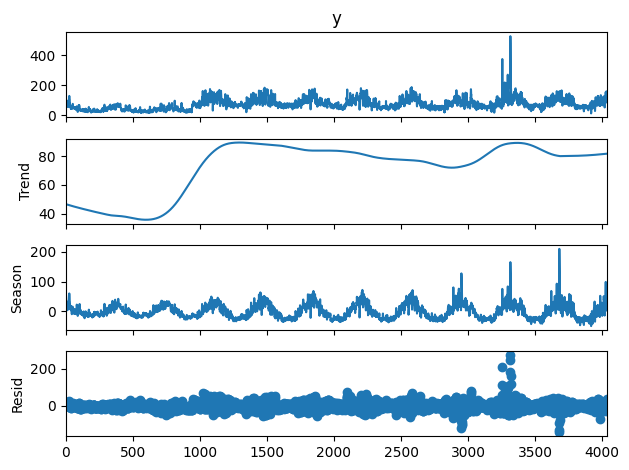

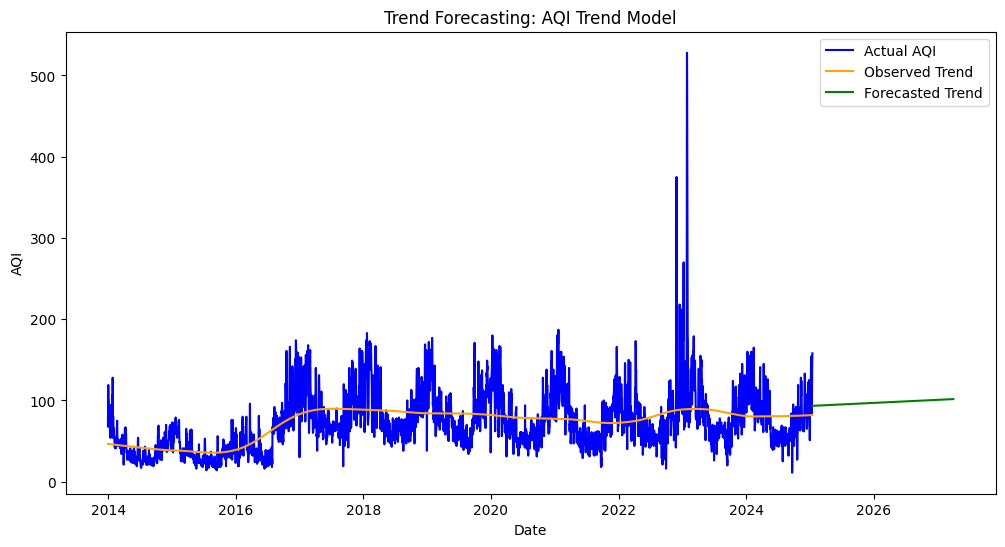

Initializing AutoARIMA model.
AutoARIMA model trained.
Forecasting 808 future data points.
AutoARIMA - MAE: 26.89, RMSE: 43.85
Hybrid (ARIMA + XGBoost) - MAE: 26.81, RMSE: 43.97


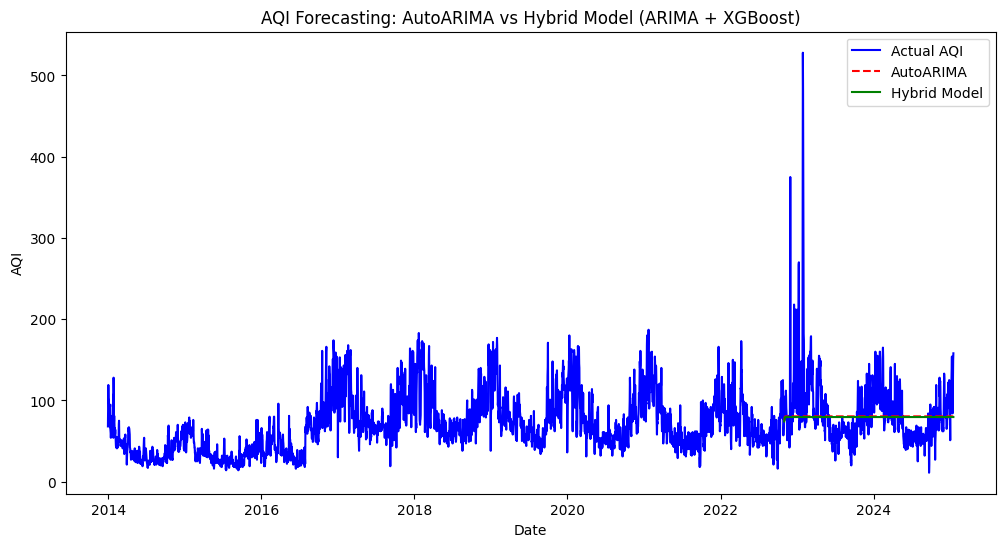

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

# Load AQI Data
data_path = r"D:\AQI_forecasting\backend\data\bangkok-air-quality.csv"
print("Loading data from:", data_path)
df = pd.read_csv(data_path)
print("Data loaded. Shape:", df.shape)

def remove_whitespace_cols(df):
    print("Removing whitespace from column names.")
    df.columns = df.columns.str.strip()
    return df

def cleaning_data(df):
    print("Cleaning data.")
    df = remove_whitespace_cols(df)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    for col in df.columns:
        if col != 'date':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)
    print("Data cleaning completed. Shape:", df.shape)
    return df

def calc_aqi(row: pd.Series):
    pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
    return np.nanmax([row[p] for p in pollutants if not np.isnan(row[p])])

def preprocess_data(df):
    print("Preprocessing data.")
    df['aqi'] = df.apply(calc_aqi, axis=1)
    df = df[['date', 'aqi']]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    # Reindex to include all dates in the range
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range)
    # Fill missing values
    df['aqi'].fillna(method='ffill', inplace=True)
    df['aqi'].fillna(method='bfill', inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'ds', 'aqi': 'y'}, inplace=True)
    df['unique_id'] = 1
    print("Data preprocessing completed. Shape:", df.shape)
    return df

df = cleaning_data(df)
df = preprocess_data(df)

# Split Train/Test Data based on date
split_date = df['ds'].quantile(0.8, interpolation='nearest')
train_df = df[df['ds'] < split_date]
test_df = df[df['ds'] >= split_date]
print(f"Splitting data: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- Trend Forecasting ---
# Decompose the AQI data using STL
stl = STL(df['y'], period=365)
result = stl.fit()
result.plot()
plt.show()

# Get the trend component
trend = result.trend
# Remove NaN values from trend component
trend = trend.dropna()

# Prepare data for trend forecasting
trend_dates = np.array(range(len(trend))).reshape(-1, 1)

# Fit a linear regression to the trend
trend_model = LinearRegression()
trend_model.fit(trend_dates, trend)

# Forecast the trend for future periods
horizon = len(test_df)  # Forecast length is equal to the test set length
future_dates = np.array(range(len(trend), len(trend) + horizon)).reshape(-1, 1)
trend_forecast = trend_model.predict(future_dates)

# --- Combine Trend Forecast ---
# Optionally, you could add the seasonal component back if desired, for now, let's plot the trend forecast alone.

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual AQI', color='blue')
plt.plot(df['ds'][:len(trend)], trend, label='Observed Trend', color='orange')
plt.plot(pd.date_range(df['ds'].iloc[-1], periods=horizon, freq='D'), trend_forecast, label='Forecasted Trend', color='green')
plt.legend()
plt.title("Trend Forecasting: AQI Trend Model")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

# --- Evaluate Hybrid Model (ARIMA + XGBoost) ---
# Train AutoARIMA and XGBoost as previously defined
models = [AutoARIMA(season_length=7)]
print("Initializing AutoARIMA model.")
sf = StatsForecast(models=models, freq='D', n_jobs=-1)
sf.fit(train_df[['unique_id', 'ds', 'y']])
print("AutoARIMA model trained.")

# Forecast with AutoARIMA
print(f"Forecasting {horizon} future data points.")
forecast_df = sf.forecast(df=train_df[['unique_id', 'ds', 'y']], h=horizon, level=[95])
test_df = test_df.merge(forecast_df, how='left', on=['unique_id', 'ds'])
test_df.rename(columns={'AutoARIMA': 'arima_pred'}, inplace=True)

# Calculate Residuals (Actual - Forecast)
test_df['residual'] = test_df['y'] - test_df['arima_pred']

# Train XGBoost on Residuals
xgb_train_X = np.arange(len(train_df)).reshape(-1, 1)
xgb_train_y = (train_df['y'] - train_df['y'].shift(1)).fillna(0)

xgb_test_X = np.arange(len(train_df), len(train_df) + len(test_df)).reshape(-1, 1)

scaler = StandardScaler()
xgb_train_y_scaled = scaler.fit_transform(xgb_train_y.values.reshape(-1, 1)).ravel()

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)
xgb_model.fit(xgb_train_X, xgb_train_y_scaled)

# Predict Residual Correction
xgb_pred_scaled = xgb_model.predict(xgb_test_X)
xgb_pred = scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).ravel()
test_df['hybrid_pred'] = test_df['arima_pred'] + xgb_pred

# Evaluate Models
mae_arima = mean_absolute_error(test_df['y'], test_df['arima_pred'])
mae_hybrid = mean_absolute_error(test_df['y'], test_df['hybrid_pred'])
rmse_arima = np.sqrt(mean_squared_error(test_df['y'], test_df['arima_pred']))
rmse_hybrid = np.sqrt(mean_squared_error(test_df['y'], test_df['hybrid_pred']))

print(f"AutoARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"Hybrid (ARIMA + XGBoost) - MAE: {mae_hybrid:.2f}, RMSE: {rmse_hybrid:.2f}")

# Plot Forecasts
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Actual AQI', color='blue')
plt.plot(test_df['ds'], test_df['arima_pred'], label='AutoARIMA', color='red', linestyle='dashed')
plt.plot(test_df['ds'], test_df['hybrid_pred'], label='Hybrid Model', color='green')
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.title("AQI Forecasting: AutoARIMA vs Hybrid Model (ARIMA + XGBoost)")
plt.show()


Loading data from: D:\AQI_forecasting\backend\data\bangkok-air-quality.csv
Data loaded. Shape: (4026, 7)
Cleaning data.
Removing whitespace from column names.
Data cleaning completed. Shape: (4026, 7)
Preprocessing data.
Data preprocessing completed. Shape: (4034, 3)
Splitting data: 3226 train samples, 808 test samples.
Initializing AutoARIMA model.
AutoARIMA point forecasts completed.
Gaussian noise added to AutoARIMA forecasts.
Residuals calculated.
Data scaled for XGBoost training.
Hybrid model point forecasts generated.
AutoARIMA + Noise - MAE: 27.25, RMSE: 44.05
Hybrid (ARIMA + XGBoost + Noise) - MAE: 27.20, RMSE: 44.17


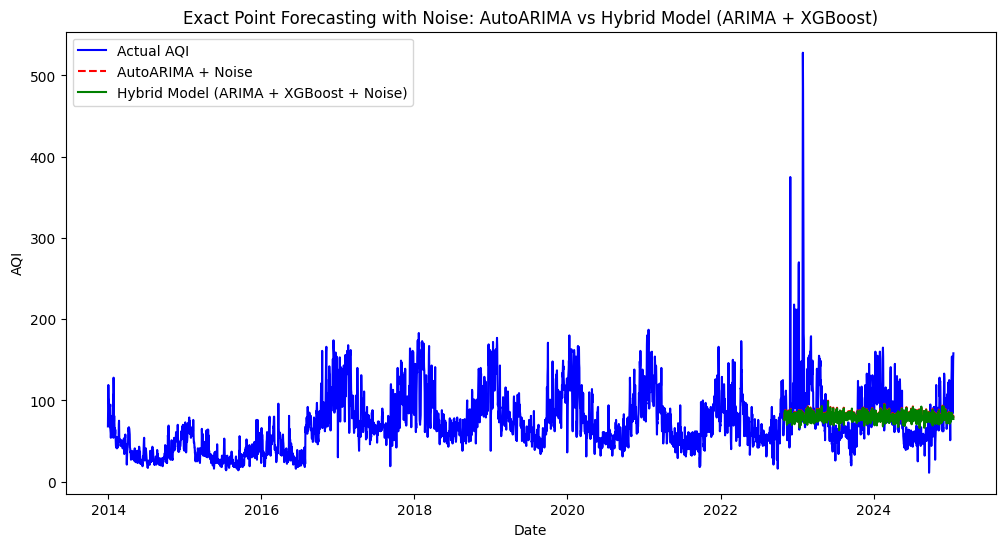

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# Load AQI Data
data_path = r"D:\AQI_forecasting\backend\data\bangkok-air-quality.csv"
print("Loading data from:", data_path)
df = pd.read_csv(data_path)
print("Data loaded. Shape:", df.shape)

def remove_whitespace_cols(df):
    print("Removing whitespace from column names.")
    df.columns = df.columns.str.strip()
    return df

def cleaning_data(df):
    print("Cleaning data.")
    df = remove_whitespace_cols(df)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    for col in df.columns:
        if col != 'date':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)
    print("Data cleaning completed. Shape:", df.shape)
    return df

def calc_aqi(row: pd.Series):
    pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
    return np.nanmax([row[p] for p in pollutants if not np.isnan(row[p])])

def preprocess_data(df):
    print("Preprocessing data.")
    df['aqi'] = df.apply(calc_aqi, axis=1)
    df = df[['date', 'aqi']]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    # Reindex to include all dates in the range
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range)
    # Fill missing values
    df['aqi'].fillna(method='ffill', inplace=True)
    df['aqi'].fillna(method='bfill', inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'ds', 'aqi': 'y'}, inplace=True)
    df['unique_id'] = 1
    print("Data preprocessing completed. Shape:", df.shape)
    return df

df = cleaning_data(df)
df = preprocess_data(df)

# Split Train/Test Data based on date
split_date = df['ds'].quantile(0.8, interpolation='nearest')
train_df = df[df['ds'] < split_date]
test_df = df[df['ds'] >= split_date]
print(f"Splitting data: {len(train_df)} train samples, {len(test_df)} test samples.")

# AutoARIMA Model (Base Point Forecast)
print("Initializing AutoARIMA model.")
sf = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
sf.fit(train_df[['unique_id', 'ds', 'y']])

# Forecast for each point in time (exact forecast)
horizon = len(test_df)  # Forecast length is equal to the test set length
forecast_df = sf.forecast(df=train_df[['unique_id', 'ds', 'y']], h=horizon, level=[95])

# Merge forecasts with actual values (for evaluation)
test_df = test_df.merge(forecast_df, how='left', on=['unique_id', 'ds'])
test_df.rename(columns={'AutoARIMA': 'arima_pred'}, inplace=True)
print("AutoARIMA point forecasts completed.")

# Add Gaussian noise to the ARIMA forecasts
np.random.seed(42)  # Set random seed for reproducibility
noise = np.random.normal(0, 5, size=len(test_df))  # Gaussian noise with mean=0 and std=5
test_df['arima_with_noise'] = test_df['arima_pred'] + noise
print("Gaussian noise added to AutoARIMA forecasts.")

# Residuals Calculation (Point Forecast Error)
test_df['residual'] = test_df['y'] - test_df['arima_with_noise']
print("Residuals calculated.")

# XGBoost Model to Predict Residuals (Point Correction)
xgb_train_X = np.arange(len(train_df)).reshape(-1, 1)
xgb_train_y = (train_df['y'] - train_df['y'].shift(1)).fillna(0)  # Train on AQI changes

xgb_test_X = np.arange(len(train_df), len(train_df) + len(test_df)).reshape(-1, 1)

scaler = StandardScaler()
xgb_train_y_scaled = scaler.fit_transform(xgb_train_y.values.reshape(-1, 1)).ravel()
print("Data scaled for XGBoost training.")

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)
xgb_model.fit(xgb_train_X, xgb_train_y_scaled)

# Predict Residual Correction for each point (Exact Forecast)
xgb_pred_scaled = xgb_model.predict(xgb_test_X)
xgb_pred = scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).ravel()

# Hybrid Model: Add Residual Prediction to ARIMA forecast with noise
test_df['hybrid_pred_with_noise'] = test_df['arima_with_noise'] + xgb_pred
print("Hybrid model point forecasts generated.")

# Evaluate Models (Point Error Metrics)
mae_arima = mean_absolute_error(test_df['y'], test_df['arima_with_noise'])
mae_hybrid = mean_absolute_error(test_df['y'], test_df['hybrid_pred_with_noise'])
rmse_arima = np.sqrt(mean_squared_error(test_df['y'], test_df['arima_with_noise']))
rmse_hybrid = np.sqrt(mean_squared_error(test_df['y'], test_df['hybrid_pred_with_noise']))

print(f"AutoARIMA + Noise - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"Hybrid (ARIMA + XGBoost + Noise) - MAE: {mae_hybrid:.2f}, RMSE: {rmse_hybrid:.2f}")

# Plot the exact point forecasts (Actual vs. Predicted with Noise)
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Actual AQI', color='blue')
plt.plot(test_df['ds'], test_df['arima_with_noise'], label='AutoARIMA + Noise', color='red', linestyle='dashed')
plt.plot(test_df['ds'], test_df['hybrid_pred_with_noise'], label='Hybrid Model (ARIMA + XGBoost + Noise)', color='green')
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.title("Exact Point Forecasting with Noise: AutoARIMA vs Hybrid Model (ARIMA + XGBoost)")
plt.show()
